In [1]:
from libra_toolbox.neutron_detection.activation_foils import *
import numpy as np
from datetime import datetime
import json

In [2]:
from libra_toolbox.neutron_detection.activation_foils.calibration import (
    CheckSource,
    co60,
    cs137,
    mn54,
    na22,
    ActivationFoil,
    nb93_n2n,
    zr90_n2n
)
import libra_toolbox.neutron_detection.activation_foils.compass as compass
from libra_toolbox.neutron_detection.activation_foils.compass import (
    Measurement,
    CheckSourceMeasurement,
    SampleMeasurement
)
from datetime import date

run_dir = "../../data/neutron_detection/activation_foils/DAQ"
uCi_to_Bq = 3.7e4

co60_checksource = CheckSource(
    co60, activity_date=date(2014, 3, 19), activity=0.872 * uCi_to_Bq
)
cs137_checksource = CheckSource(
    cs137, activity_date=date(2023, 9, 29), activity=9.38 * uCi_to_Bq
)
mn54_checksource = CheckSource(
    mn54, activity_date=date(2016, 5, 2), activity=6.27 * uCi_to_Bq
)
na22_checksource = CheckSource(
    na22, activity_date=date(2023, 9, 29), activity=9.98 * uCi_to_Bq
)

check_source_measurements = {
    "Co60_1": {
        "directory": f"{run_dir}/Co60_0_872uCi_2014Mar19_count1/UNFILTERED",
        "check_source": co60_checksource,
    },
    "Co60_2": {
        "directory": f"{run_dir}/Co60_0_872uCi_2014Mar19_count2/UNFILTERED",
        "check_source": co60_checksource,
    },
    "Cs137_1": {
        "directory": f"{run_dir}/Cs137_9_38uCi_2023Sep29_count1/UNFILTERED",
        "check_source": cs137_checksource,
    },
    "Cs137_2": {
        "directory": f"{run_dir}/Cs137_9_38uCi_2023Sep29_count2/UNFILTERED",
        "check_source": cs137_checksource,
    },
    "Mn54_1": {
        "directory": f"{run_dir}/Mn54_6_27uCi_2016May2_count1/UNFILTERED",
        "check_source": mn54_checksource,
    },
    "Mn54_2": {
        "directory": f"{run_dir}/Mn54_6_27uCi_2016May2_count2/UNFILTERED",
        "check_source": mn54_checksource,
    },
    "Na22_1": {
        "directory": f"{run_dir}/Na22_9_98uCi_2023Sep29_count1/UNFILTERED",
        "check_source": na22_checksource,
    },
    "Na22_2": {
        "directory": f"{run_dir}/Na22_9_98uCi_2023Sep29_count2/UNFILTERED",
        "check_source": na22_checksource,
    },
}

background_dir = f"{run_dir}/Background_20250602_count1/UNFILTERED"

In [3]:
all_measurements = {}

for name, values in check_source_measurements.items():
    print(f"Processing {name}...")
    meas = CheckSourceMeasurement.from_directory(values["directory"], name=name)
    meas.check_source = values["check_source"]
    print(meas)
    all_measurements[name] = meas

print(f"Processing background...")
background_meas = Measurement.from_directory(
    background_dir,
    name="Background",
    info_file_optional=True,
)

Processing Co60_1...
Processing Co60_2...
Processing Cs137_1...
Processing Cs137_2...
Processing Mn54_1...
Processing Mn54_2...
Processing Na22_1...
Processing Na22_2...
Processing background...


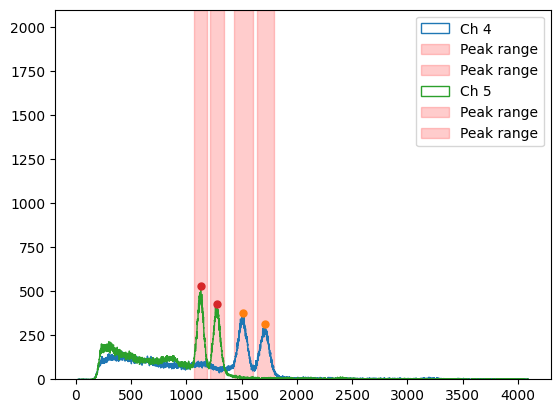

In [4]:
import matplotlib.pyplot as plt
from libra_toolbox.neutron_detection.activation_foils import compass

for detector in all_measurements["Co60_1"].detectors:
    hist, bin_edges = detector.get_energy_hist()

    plt.hist(
        bin_edges[:-1],
        bins=bin_edges,
        weights=hist,
        histtype="step",
        label=f"Ch {detector.channel_nb}",
    )
    peaks = all_measurements["Co60_1"].get_peaks(hist)
    # plt.plot(bin_edges[peaks], hist[peaks], '.', ms=10)

    from scipy.signal import find_peaks
    import numpy as np

    start_index = 400
    height = 0.60 * np.max(hist[start_index:])
    prominence = None
    width = [10, 150]
    distance = 30
    peaks, peak_data = find_peaks(
        hist[start_index:],
        prominence=prominence,
        height=height,
        width=width,
        distance=distance,
    )
    plt.plot(bin_edges[start_index:][peaks], peak_data["peak_heights"], ".", ms=10)

    for i, p in enumerate(peaks):
        width = peak_data["widths"][i]
        plt.axvspan(
            bin_edges[start_index:][p] - width,
            bin_edges[start_index:][p] + width,
            color="red",
            alpha=0.2,
            label="Peak range",
        )

plt.legend()
# plt.yscale("log")
plt.ylim(top=2100)
plt.show()

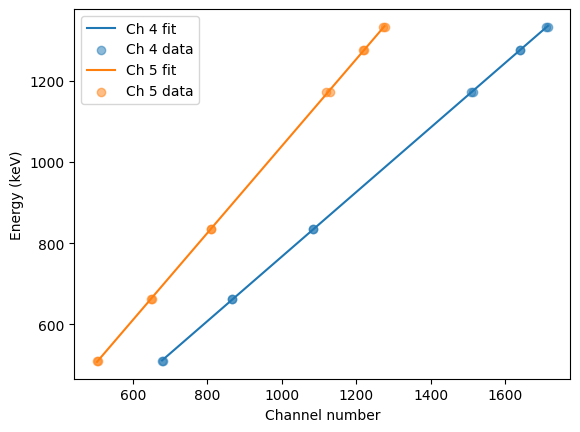

In [5]:
calibration_coeffs = {}

for channel_nb in [4, 5]:
    calibration_channels, calibration_energies = compass.get_calibration_data(
        all_measurements.values(),
        background_measurement=background_meas,
        channel_nb=channel_nb,
    )

    coeff = np.polyfit(calibration_channels, calibration_energies, 1)
    calibration_coeffs[channel_nb] = coeff

    xs = np.linspace(
        calibration_channels[0],
        calibration_channels[-1],
    )
    plt.plot(
        xs,
        np.polyval(coeff, xs),
        label=f"Ch {channel_nb} fit",
    )
    plt.scatter(
        calibration_channels,
        calibration_energies,
        label=f"Ch {channel_nb} data",
        alpha=0.5,
    )
plt.xlabel("Channel number")
plt.ylabel("Energy (keV)")
plt.legend()
plt.show()

In [6]:
def eff_curve_func(E, a0, a1, a2, a3
                #    , a4
                   ):
    out = np.exp(
        a0
        + a1 * np.log(E)
        + a2 * (np.log(E) ** 2)
        + a3 * (np.log(E) ** 3)
        # + a4 * (np.log(E) ** 4)
    )
    return out

In [7]:
# from scipy import signal
# cutoff = 0.3
# order = 4
# b, a = signal.butter(order, cutoff, btype='low', analog=False)

# channels = []
# measurement = list(all_measurements.values())[0]
# for detector in measurement.detectors:
#     channels.append(detector.channel_nb)

# for ch in channels:
#     for measurement in all_measurements.values():
#         detector = measurement.get_detector(ch)
#         detector.events[:,1] = signal.filtfilt(b, a, detector.events[:,1])

Ch 4 
	 Energies: [ 511.     511.     661.657  661.657  834.848  834.848 1173.228 1173.228
 1274.537 1274.537 1332.492 1332.492], 
	 Efficiencies: [0.02101647 0.02748761 0.019778   0.02085601 0.01490032 0.01629768
 0.01028258 0.01069238 0.01083761 0.01146024 0.00939956 0.00978586]
[-384.03755543  171.81951692  -25.72015877    1.27441254]
Ch 5 
	 Energies: [ 511.     511.     661.657  661.657  834.848  834.848 1173.228 1173.228
 1274.537 1274.537 1332.492 1332.492], 
	 Efficiencies: [0.03573465 0.02785796 0.02779036 0.02641292 0.02137966 0.01970774
 0.01435001 0.01369789 0.01492023 0.01428735 0.01276093 0.01200887]
[-398.94298007  178.18230927  -26.60255567    1.3148777 ]


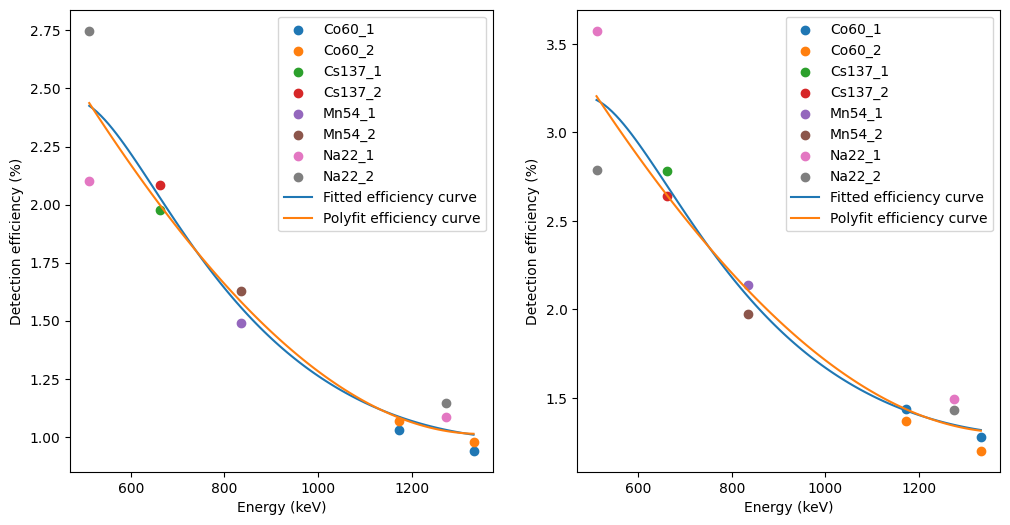

In [8]:
from scipy.optimize import curve_fit

channels = []
efficiency_coeffs = {}
measurement = list(all_measurements.values())[0]
search_widths = {4: 330, 5:330}

for detector in measurement.detectors:
    channels.append(detector.channel_nb)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for i,ch in enumerate(channels):
    background_detector = background_meas.get_detector(ch)
    energies = []
    efficiencies = []
    for name, measurement in all_measurements.items():
        check_source_detector = measurement.get_detector(ch)
        hist, bin_edges = check_source_detector.get_energy_hist_background_substract(background_detector)
        calibrated_bin_edges = np.polyval(calibration_coeffs[ch], bin_edges)
        # fig, ax = plt.subplots()
        # ax.stairs(hist, calibrated_bin_edges)
        # ax.set_title(f'Ch {ch}: ' + name)
        # ax.set_yscale("symlog")

        # nb_counts_measured = compass.get_multipeak_area(
        #     hist,
        #     calibrated_bin_edges,
        #     measurement.check_source.nuclide.energy,
        #     search_width=search_widths[ch],
        # )
        # print(f"{name} - Ch {ch}: {nb_counts_measured} counts measured")
        
        efficiency = measurement.compute_detection_efficiency(
            background_measurement=background_meas,
            calibration_coeffs=calibration_coeffs[ch],
            channel_nb=ch,
            search_width=search_widths[ch],
        )
        energies += measurement.check_source.nuclide.energy
        efficiencies += list(efficiency)
        ax[i].scatter(
            measurement.check_source.nuclide.energy,
            efficiency * 100,
            label=name,
        )

    # Sort energies and efficiencies for fitting
    sorted_indices = np.argsort(energies)
    energies = np.array(energies)[sorted_indices]
    efficiencies = np.array(efficiencies)[sorted_indices]
    print(f"Ch {ch} \n\t Energies: {energies}, \n\t Efficiencies: {efficiencies}")

    # Fit the efficiency curve
    popt, pcov = curve_fit(
        eff_curve_func,
        energies,
        efficiencies,
        p0=[-1, 1, 0, 0],
    )

    poly_coeff = np.polyfit(energies, efficiencies, 3)
    efficiency_coeffs[ch] = poly_coeff
    xs = np.linspace(
        energies[0],
        energies[-1],
        100,
    )
    ax[i].plot(
        xs,
        eff_curve_func(xs, *popt) * 100,
        label="Fitted efficiency curve",
    )

    ax[i].plot(
        xs,
        np.polyval(poly_coeff, xs) * 100,
        label="Polyfit efficiency curve",
    )
    ax[i].set_xlabel("Energy (keV)")
    ax[i].set_ylabel("Detection efficiency (%)")
    ax[i].legend()
    # plt.ylim(bottom=0)
    print(popt)
plt.show()

In [9]:
from zoneinfo import ZoneInfo

with open("../../data/general.json", "r") as f:
    general_data = json.load(f)
irradiations = []
for generator in general_data["generators"]:
    if generator["enabled"] is False:
        continue
    for i,irradiation_period in enumerate(generator["periods"]):
        if i==0:
            overall_start_time = datetime.strptime(irradiation_period["start"], "%m/%d/%Y %H:%M")
        start_time = datetime.strptime(irradiation_period["start"], "%m/%d/%Y %H:%M")
        end_time = datetime.strptime(irradiation_period["end"], "%m/%d/%Y %H:%M")
        irradiations.append({"t_on": (start_time - overall_start_time).total_seconds(),
                             "t_off": (end_time - overall_start_time).total_seconds()})
time_generator_off = end_time
time_generator_off = time_generator_off.replace(tzinfo=ZoneInfo("America/New_York"))
print(irradiations)


[{'t_on': 0.0, 't_off': 3600.0}]


In [10]:
all_neutron_rates = []
all_neutron_rates_err = []

In [11]:
niobium3 = ActivationFoil(
    reaction=nb93_n2n,
    mass=0.5359,
    name="Niobium #3",
    density=8.582,
    thickness=0.01 * 2 * 2.54,  # 0.01 inch in cm
)
niobium3.mass_attenuation_coefficient = 0.06120 # cm^2/g at 1 MeV

# Get distance to generator
with open("../../data/general.json", "r") as f:
    general_data = json.load(f)
    foils = general_data["neutron_detection"]["foils"]["materials"]
    for foil in foils:
        if foil["material"] == "Nb":
            distance_to_source_dict = foil["distance_to_source"]
            if distance_to_source_dict["unit"] == "cm":
                distance_to_source = distance_to_source_dict["value"]
            else:
                raise ValueError(
                    f"Unsupported unit for distance to source: {distance_to_source_dict['unit']}"
                )


        

In [12]:
niobium3_measurement1 = SampleMeasurement.from_directory(
    source_dir=f"{run_dir}/Niobium3_20250601_1358_count1/UNFILTERED",
    name="Niobium3_count1")
niobium3_measurement1.foil = niobium3


for detector in niobium3_measurement1.detectors:
    ch = detector.channel_nb

    gamma_emitted, gamma_emitted_err = niobium3_measurement1.get_gamma_emitted(
        background_measurement=background_meas,
        calibration_coeffs=calibration_coeffs[ch],
        efficiency_coeffs=efficiency_coeffs[ch],
        channel_nb=ch,
        search_width=330)
    
    neutron_rate = niobium3_measurement1.get_neutron_rate(
        channel_nb=ch,
        photon_counts=gamma_emitted,
        irradiations=irradiations,
        distance=distance_to_source,
        time_generator_off=time_generator_off,
        branching_ratio=niobium3.reaction.product.intensity
    )

    neutron_rate_err = niobium3_measurement1.get_neutron_rate(
        channel_nb=ch,
        photon_counts=gamma_emitted_err,
        irradiations=irradiations,
        distance=distance_to_source,
        time_generator_off=time_generator_off,
        branching_ratio=niobium3.reaction.product.intensity
    )
    print(f"Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s, \n\t Gamma emitted: {gamma_emitted} ± {gamma_emitted_err} counts")
    all_neutron_rates.append(neutron_rate[0])
    all_neutron_rates_err.append(neutron_rate_err[0])


Ch 5: Neutron rate: 1.356e+09 +/- 9.869e+06 n/s, 
	 Gamma emitted: [1017208.07445554] ± [7405.99845477] counts
Ch 4: Neutron rate: 1.398e+09 +/- 1.158e+07 n/s, 
	 Gamma emitted: [1048974.39373851] ± [8688.44807371] counts


In [13]:
niobium3_measurement2 = SampleMeasurement.from_directory(
    source_dir=f"{run_dir}/Niobium3_20250602_1123_count2/UNFILTERED",
    name="Niobium3_count1")
niobium3_measurement2.foil = niobium3


for detector in niobium3_measurement2.detectors:
    ch = detector.channel_nb

    gamma_emitted, gamma_emitted_err = niobium3_measurement2.get_gamma_emitted(
        background_measurement=background_meas,
        calibration_coeffs=calibration_coeffs[ch],
        efficiency_coeffs=efficiency_coeffs[ch],
        channel_nb=ch,
        search_width=330)
    
    neutron_rate = niobium3_measurement2.get_neutron_rate(
        channel_nb=ch,
        photon_counts=gamma_emitted,
        irradiations=irradiations,
        distance=distance_to_source,
        time_generator_off=time_generator_off,
        branching_ratio=niobium3.reaction.product.intensity
    )

    neutron_rate_err = niobium3_measurement2.get_neutron_rate(
        channel_nb=ch,
        photon_counts=gamma_emitted_err,
        irradiations=irradiations,
        distance=distance_to_source,
        time_generator_off=time_generator_off,
        branching_ratio=niobium3.reaction.product.intensity
    )
    print(f"Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s, \n\t Gamma emitted: {gamma_emitted} ± {gamma_emitted_err} counts")
    all_neutron_rates.append(neutron_rate[0])
    all_neutron_rates_err.append(neutron_rate_err[0])

Ch 4: Neutron rate: 1.376e+09 +/- 1.687e+07 n/s, 
	 Gamma emitted: [478793.34483805] ± [5869.94212135] counts
Ch 5: Neutron rate: 1.456e+09 +/- 1.502e+07 n/s, 
	 Gamma emitted: [507126.62247336] ± [5229.22011081] counts


In [14]:
zirconium1 = ActivationFoil(
    reaction=zr90_n2n,
    mass=0.9036,
    name="Zirconium #1",
    density=6.505,
    thickness=0.005 * 8 * 2.54,  # 0.01 inch in cm
)
zirconium1.mass_attenuation_coefficient = 0.08590  # cm^2/g

# Get distance to generator
with open("../../data/general.json", "r") as f:
    general_data = json.load(f)
    foils = general_data["neutron_detection"]["foils"]["materials"]
    for foil in foils:
        if foil["material"] == "Zr":
            distance_to_source_dict = foil["distance_to_source"]
            if distance_to_source_dict["unit"] == "cm":
                distance_to_source = distance_to_source_dict["value"]
            else:
                raise ValueError(
                    f"Unsupported unit for distance to source: {distance_to_source_dict['unit']}"
                )
print(f"Distance to source: {distance_to_source} cm")

Distance to source: 4.5 cm


In [15]:
zirconium1_measurement1 = SampleMeasurement.from_directory(
    source_dir=f"{run_dir}/Zirconium1_20250530_1512_count1/UNFILTERED",
    name="Zirconium1_count1")
zirconium1_measurement1.foil = zirconium1


for detector in zirconium1_measurement1.detectors:
    ch = detector.channel_nb

    gamma_emitted, gamma_emitted_err = zirconium1_measurement1.get_gamma_emitted(
        background_measurement=background_meas,
        calibration_coeffs=calibration_coeffs[ch],
        efficiency_coeffs=efficiency_coeffs[ch],
        channel_nb=ch,
        search_width=330)
    
    neutron_rate = zirconium1_measurement1.get_neutron_rate(
        channel_nb=ch,
        photon_counts=gamma_emitted,
        irradiations=irradiations,
        distance=distance_to_source,
        time_generator_off=time_generator_off,
        branching_ratio=zirconium1.reaction.product.intensity
    )

    neutron_rate_err = zirconium1_measurement1.get_neutron_rate(
        channel_nb=ch,
        photon_counts=gamma_emitted_err,
        irradiations=irradiations,
        distance=distance_to_source,
        time_generator_off=time_generator_off,
        branching_ratio=zirconium1.reaction.product.intensity
    )
    print(f"Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s, \n\t Gamma emitted: {gamma_emitted} ± {gamma_emitted_err} counts")
    all_neutron_rates.append(neutron_rate[0])
    all_neutron_rates_err.append(neutron_rate_err[0])

Ch 4: Neutron rate: 1.188e+09 +/- 5.623e+06 n/s, 
	 Gamma emitted: [3076083.95177954] ± [14554.95312935] counts
Ch 5: Neutron rate: 1.163e+09 +/- 4.815e+06 n/s, 
	 Gamma emitted: [3012915.99276434] ± [12472.91112212] counts


In [16]:
zirconium1_measurement2 = SampleMeasurement.from_directory(
    source_dir=f"{run_dir}/Zirconium1_20250531_2115_count2/UNFILTERED",
    name="Zirconium1_count2")
zirconium1_measurement2.foil = zirconium1


for detector in zirconium1_measurement2.detectors:
    ch = detector.channel_nb

    gamma_emitted, gamma_emitted_err = zirconium1_measurement2.get_gamma_emitted(
        background_measurement=background_meas,
        calibration_coeffs=calibration_coeffs[ch],
        efficiency_coeffs=efficiency_coeffs[ch],
        channel_nb=ch,
        search_width=330)
    
    neutron_rate = zirconium1_measurement2.get_neutron_rate(
        channel_nb=ch,
        photon_counts=gamma_emitted,
        irradiations=irradiations,
        distance=distance_to_source,
        time_generator_off=time_generator_off,
        branching_ratio=zirconium1.reaction.product.intensity
    )

    neutron_rate_err = zirconium1_measurement2.get_neutron_rate(
        channel_nb=ch,
        photon_counts=gamma_emitted_err,
        irradiations=irradiations,
        distance=distance_to_source,
        time_generator_off=time_generator_off,
        branching_ratio=zirconium1.reaction.product.intensity
    )
    print(f"Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s, \n\t Gamma emitted: {gamma_emitted} ± {gamma_emitted_err} counts")
    all_neutron_rates.append(neutron_rate[0])
    all_neutron_rates_err.append(neutron_rate_err[0])

Ch 5: Neutron rate: 1.157e+09 +/- 5.484e+06 n/s, 
	 Gamma emitted: [2296873.61629899] ± [10890.37578732] counts
Ch 4: Neutron rate: 1.173e+09 +/- 6.378e+06 n/s, 
	 Gamma emitted: [2328972.31080504] ± [12664.6701137] counts


In [18]:
average_neutron_rate = np.mean(all_neutron_rates)
# average_neutron_rate_err = np.sqrt(np.sum(np.array(all_neutron_rates_err) ** 2)) / len(all_neutron_rates_err)
average_neutron_rate_err = np.std(all_neutron_rates, ddof=1)  # Use ddof=1 for sample standard deviation

print(f"Average neutron rate: {average_neutron_rate:.3e} ± {average_neutron_rate_err:.3e} n/s")

Average neutron rate: 1.283e+09 ± 1.246e+08 n/s
